# Test Loading data and basic pre processing

In [28]:
import torch
import h5py

import matplotlib.pyplot as plt

## Load Data from h5 file

In [2]:
file_path='/home/squirt/Documents/data/rp_weather_data/all_data.h5'

In [3]:
def load_hdf5(filename):
    data = []  # List to hold dictionaries
    with h5py.File(filename, 'r') as f:
        # Iterate through groups (each representing an entry in the original list)
        for group_name in f:
            group = f[group_name]
            # Reconstruct dictionary from datasets and attributes
            entry = {
                # Attributes (metadata)
                'day': group.attrs['day'],
                'region': group.attrs['region'],
                'time': group.attrs['time'],

                # groups (numpy arrays)
                'landmass': group['landmass'][...],  # Use [...] to read the full dataset
                'x': group['x'][...],
                'y': group['y'][...],
            }
            data.append(entry)
    return data

In [4]:
data_list = load_hdf5(file_path)

In [5]:
data_list[0]['x'].shape

(3, 70, 2, 2)

In [6]:
def stack_data(data:list[dict], key:str) -> torch.Tensor:
    return torch.stack([torch.tensor(entry[key]) for entry in data])

In [7]:
X = stack_data(data_list, 'x')

In [8]:
print(X.shape)

torch.Size([19200, 3, 70, 2, 2])


In [9]:
LM = stack_data(data_list, 'landmass')
Y = stack_data(data_list, 'y')

In [11]:
print(LM.shape)
print(Y.shape)

torch.Size([19200, 3, 2, 2])
torch.Size([19200, 2, 70, 2, 2])


In [17]:
print(Y[0,0,0,:])
print(data_list[0]['y'][0,0,:])

tensor([[3.1161, 2.6633],
        [1.9113, 2.4286]], dtype=torch.float64)
[[3.11609554 2.66331124]
 [1.91130269 2.42855477]]


In [19]:
def normalize_tensor(data):
    # Compute mean and std along the batch_size, x1, and x2 dimensions
    mean = data.mean(dim=(0, 3, 4), keepdim=True)
    std = data.std(dim=(0, 3, 4), keepdim=True)
    
    # Normalize the data
    normalized_data = (data - mean) / (std + 1e-7)  # Add a small constant to avoid division by zero
    
    return normalized_data, mean, std

In [20]:
normalized_X, mean_X, std_X = normalize_tensor(X)

In [23]:
print(normalized_X[0,:,0,:])

tensor([[[-2.9658, -3.3713],
         [-3.2182, -3.3078]],

        [[-1.4642, -1.4844],
         [-1.4730, -1.4778]],

        [[-5.0000, -5.6815],
         [-5.5651, -5.8456]]], dtype=torch.float64)


In [26]:
print(torch.min(normalized_X[:,0,0,:]), torch.max(normalized_X[:,0,0,:]))

tensor(-3.5181, dtype=torch.float64) tensor(1.8837, dtype=torch.float64)


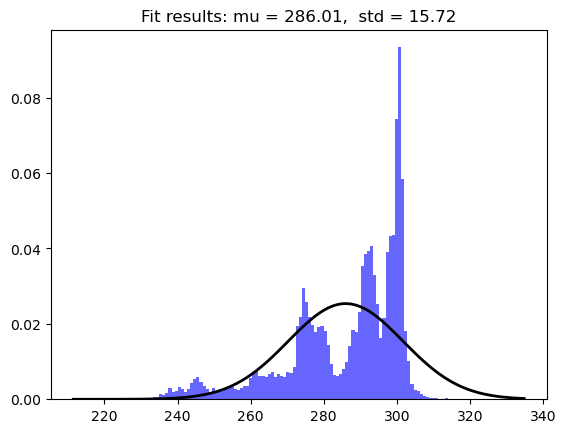

In [37]:
x_cell_1 = X[:,0,0,:]  # Extract the first cell of the first sample
x_cell_1, _ = torch.sort(x_cell_1.flatten())

def plot_tensor(t):
    import scipy.stats as stats
    import numpy as np

    #plt.plot(t.numpy())
    #plt.show()
    plt.hist(t.numpy(), bins=100, density=True, alpha=0.6, color='b')
    xmin, xmax = plt.xlim()
    x_lin = np.linspace(xmin-15, xmax+15, 100)
    p = stats.norm.pdf(x_lin, np.mean(t.numpy()), np.std(t.numpy()))
    plt.plot(x_lin, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (np.mean(t.numpy()), np.std(t.numpy()))
    plt.title(title)
    plt.show()

plot_tensor(x_cell_1)